Adjusting ResNet architecture for use with MNIST dataset. Training ResNet-18 from scratch.

Code:<br>
https://zablo.net/blog/post/using-resnet-for-mnist-in-pytorch-tutorial/ <br>

Check the GPU assigned:

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr 21 09:57:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install  PyTorch
!pip install torch torchvision

In [3]:
import torch
torch.__version__

'1.8.1+cu101'

In [4]:
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

## Define the model

In order to use this model on MNIST, input layer needs to accept single channel instead of 3. This is because MNIST images are single-channel (grayscale), whereas the model is set up to be used with ImageNet, which is 3-channel (RGB).

In [5]:
ResNet

torchvision.models.resnet.ResNet

In [6]:
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)

In [7]:
# select the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# define the model
model = MnistResNet().to(device)

In [8]:
# view the details of the model
model

MnistResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

## Set variables

In [9]:
epochs = 10
batch_size = 128
learning_rate = 1e-4

## Download data
Loading MNIST data. Images need to be rescaled and numbers normalised.

In [10]:
def get_data_loaders(train_batch_size, val_batch_size):
    mnist = MNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = Compose([ Resize((224, 224)),ToTensor(), Normalize(mean=(0.1307,), std=(0.3081,))])

    train_loader = DataLoader(MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(MNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [11]:
# load the data to variables
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Run the model

In [12]:
# helper function
def calculate_metric(metric_fn, true_y, pred_y):
  # multi class problems need to have averaging methods
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
  # a utility printing mfunction
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [13]:
# import datetime to include in submission
from datetime import datetime

In [14]:
start_ts = time.time()

now_start = datetime.now()
print(f"Starting training with {epochs} epochs on {now_start.strftime('%d/%m/%Y %H:%M:%S')}")


losses_train = []
losses_val = []
accuracies = []
# loss function, corss entropy works well for multi-class problems
loss_function = nn.CrossEntropyLoss()
# an optimiser
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(epochs):
    total_loss = 0
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unnecessary memory in GPU 
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X) # this gets the prediction from the network
            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from networks prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
        
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses_train.append(total_loss/batches) # for plotting learning curve
    losses_val.append(float((val_losses/val_batches).cpu()))
    accuracies.append(sum(accuracy)/len(accuracy))
print("Training losses:")
print(losses_train)
print("Validation losses:")
print(losses_val)
print("Accuracies:")
print(accuracies)
print()
now_end = datetime.now()
print(f"Training finished at {now_end.strftime('%d/%m/%Y %H:%M:%S')}")
print(f"Training time: {(time.time()-start_ts)/60} minutes")

Starting training with 10 epochs on 21/04/2021 09:58:26



Epoch 1/10, training loss: 1.55102988397643, validation loss: 1.4819594621658325
	     precision: 0.9856
	        recall: 0.9859
	            F1: 0.9850
	      accuracy: 0.9858



Epoch 2/10, training loss: 1.47535874213237, validation loss: 1.476737141609192
	     precision: 0.9880
	        recall: 0.9878
	            F1: 0.9872
	      accuracy: 0.9878



Epoch 3/10, training loss: 1.4712126679511974, validation loss: 1.4705190658569336
	     precision: 0.9929
	        recall: 0.9933
	            F1: 0.9928
	      accuracy: 0.9931



Epoch 4/10, training loss: 1.4688244356529545, validation loss: 1.477075457572937
	     precision: 0.9869
	        recall: 0.9865
	            F1: 0.9858
	      accuracy: 0.9867



Epoch 5/10, training loss: 1.4671164507042371, validation loss: 1.4697457551956177
	     precision: 0.9921
	        recall: 0.9921
	            F1: 0.9917
	      accuracy: 0.9922



Epoch 6/10, training loss: 1.4662560171155787, validation loss: 1.4729832410812378
	     precision: 0.9912
	        recall: 0.9907
	            F1: 0.9905
	      accuracy: 0.9907



Epoch 7/10, training loss: 1.466361854376315, validation loss: 1.4708607196807861
	     precision: 0.9917
	        recall: 0.9916
	            F1: 0.9912
	      accuracy: 0.9917



Epoch 8/10, training loss: 1.4648306664627497, validation loss: 1.4763258695602417
	     precision: 0.9872
	        recall: 0.9875
	            F1: 0.9865
	      accuracy: 0.9871



Epoch 9/10, training loss: 1.464616098129419, validation loss: 1.468401312828064
	     precision: 0.9940
	        recall: 0.9942
	            F1: 0.9938
	      accuracy: 0.9943



Epoch 10/10, training loss: 1.4642157267405789, validation loss: 1.471557855606079
	     precision: 0.9914
	        recall: 0.9904
	            F1: 0.9904
	      accuracy: 0.9905
Training losses:
[1.55102988397643, 1.47535874213237, 1.4712126679511974, 1.4688244356529545, 1.4671164507042371, 1.4662560171155787, 1.466361854376315, 1.4648306664627497, 1.464616098129419, 1.4642157267405789]
Validation losses:
[1.4819594621658325, 1.476737141609192, 1.4705190658569336, 1.477075457572937, 1.4697457551956177, 1.4729832410812378, 1.4708607196807861, 1.4763258695602417, 1.468401312828064, 1.471557855606079]
Accuracies:
[0.9857594936708861, 0.9878362341772152, 0.9930775316455697, 0.986748417721519, 0.9921875, 0.9907041139240507, 0.9916930379746836, 0.9871439873417721, 0.9942642405063291, 0.990506329113924]

Training finished at 21/04/2021 10:20:33
Training time: 22.129368404547375 minutes


Plot the training and validation loss

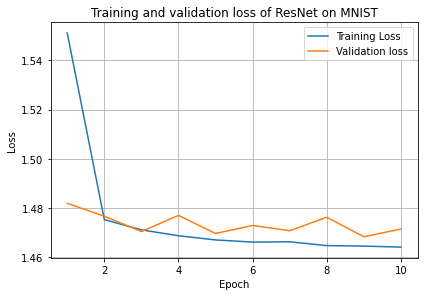

In [15]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, losses_train, label = "Training Loss")
plt.plot(x, losses_val, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()
plt.title('Training and validation loss of ResNet on MNIST')
plt.savefig('Mnist_ResNet_Train.png')
plt.show()

Plot accuracy

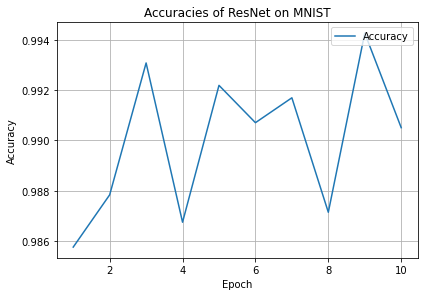

In [16]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, accuracies, label = "Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()
plt.title('Accuracies of ResNet on MNIST')
plt.savefig('Mnist_ResNet_Accuracy.png')
plt.show()

Export values for loss and accuracy to a CSV file for later plotting/evaluation.

In [17]:
import pandas as pd
data = {'Data': 'MNIST', 'Model': 'ResNet', 'Epoch': x, 'Training loss': losses_train,
     'Validation loss': losses_val, 'Accuracy': accuracies}
df = pd.DataFrame(data)
df.to_csv('MNIST_ResNet.csv', index=False)